In [34]:
pip install -r requirements.txt

  Using cached argon2_cffi-25.1.0-py3-none-any.whl (14 kB)
  Using cached argon2_cffi_bindings-25.1.0-cp39-abi3-manylinux_2_26_x86_64.manylinux_2_28_x86_64.whl (87 kB)
  Using cached asttokens-3.0.0-py3-none-any.whl (26 kB)
  Using cached async_lru-2.0.5-py3-none-any.whl (6.1 kB)
  Using cached attrs-25.3.0-py3-none-any.whl (63 kB)
  Using cached babel-2.17.0-py3-none-any.whl (10.2 MB)
  Using cached beautifulsoup4-4.13.5-py3-none-any.whl (105 kB)
  Using cached bleach-6.2.0-py3-none-any.whl (163 kB)
  Using cached cffi-2.0.0-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (215 kB)
  Using cached charset_normalizer-3.4.3-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (150 kB)
  Using cached click-8.2.1-py3-none-any.whl (102 kB)
  Using cached comm-0.2.3-py3-none-any.whl (7.3 kB)
  Using cached dask-2025.9.1-py3-none-any.whl (1.5 MB)
  Using cached debugpy-1.8.16-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylin

In [2]:
# Import required libraries
import warnings
import regionmask
import netCDF4
import h5netcdf
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import geopandas as gpd
import xarray as xr
import xgboost as xgb
from matplotlib.colors import Normalize
from matplotlib.patches import Patch
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, LeaveOneGroupOut, GridSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFE, VarianceThreshold
from scipy.stats import linregress
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
print("all libraries loaded")

all libraries loaded


At first, we need crop yield data and explore it. The data used in this practical is provided from the Joint Research Centre. It can be found on https://agri4cast.jrc.ec.europa.eu/dataportal

In [5]:
print('\n📊 STEP 1: Loading and exploring crop yield data')

# Load the crop yield CSV file
# Expected columns: NUTS3_ID, Country, Year, Crop, Yield_tonnes_per_ha
yield_data = pd.read_csv('data/yield_data_eurostat.csv', sep=';')

# Show first few rows
print(f'\n🔍 First 5 rows of the dataset:')
print(yield_data.head())
yield_data.loc[:, 'COUNTRY'] = [a[:2] for a in yield_data['IDREGION']]

# Display basic information about the dataset
print(f"\n📋 Dataset Overview:")
print(f"   • Time period: {yield_data['YEAR'].min()} - {yield_data['YEAR'].max()}")
print(f"   • Countries: {yield_data['COUNTRY'].nunique()} ({', '.join(yield_data['COUNTRY'].unique())})")
print(f"   • Crops: {yield_data['CROP_NAME'].nunique()} ({', '.join(yield_data['CROP_NAME'].unique())})")
print(f"   • Number of NUTS3 regions: {yield_data['IDREGION'].nunique()}")


📊 STEP 1: Loading and exploring crop yield data

🔍 First 5 rows of the dataset:
  IDREGION      CROP_NAME VARIABLE  YEAR  VALUE
0    ES120  Spring barley    Yield  2020    0.0
1    ITH10  Spring barley    Yield  2012    0.0
2    ITH10  Spring barley    Yield  2013    0.0
3    ITH10  Spring barley    Yield  2014    0.0
4    ITH10  Spring barley    Yield  2016    0.0

📋 Dataset Overview:
   • Time period: 2000 - 2024
   • Countries: 27 (ES, IT, RO, FR, PL, PT, NL, SI, SE, SK, LV, MT, FI, EL, BE, CZ, BG, CY, DE, LU, DK, EE, HU, LT, HR, AT, IE)
   • Crops: 2 (Spring barley, Grain maize)
   • Number of NUTS3 regions: 916


In such dataset, there are often many unusuable values like 0, nan, and unrealistic high values. Hence, we need to do some data cleaning.

📊 Original dataset size: 26378 rows
❌ Removed:
3999 rows with zero and negative yield values
3 rows with NaN values
11 outlier rows
✅ Clean dataset size: 22365 rows


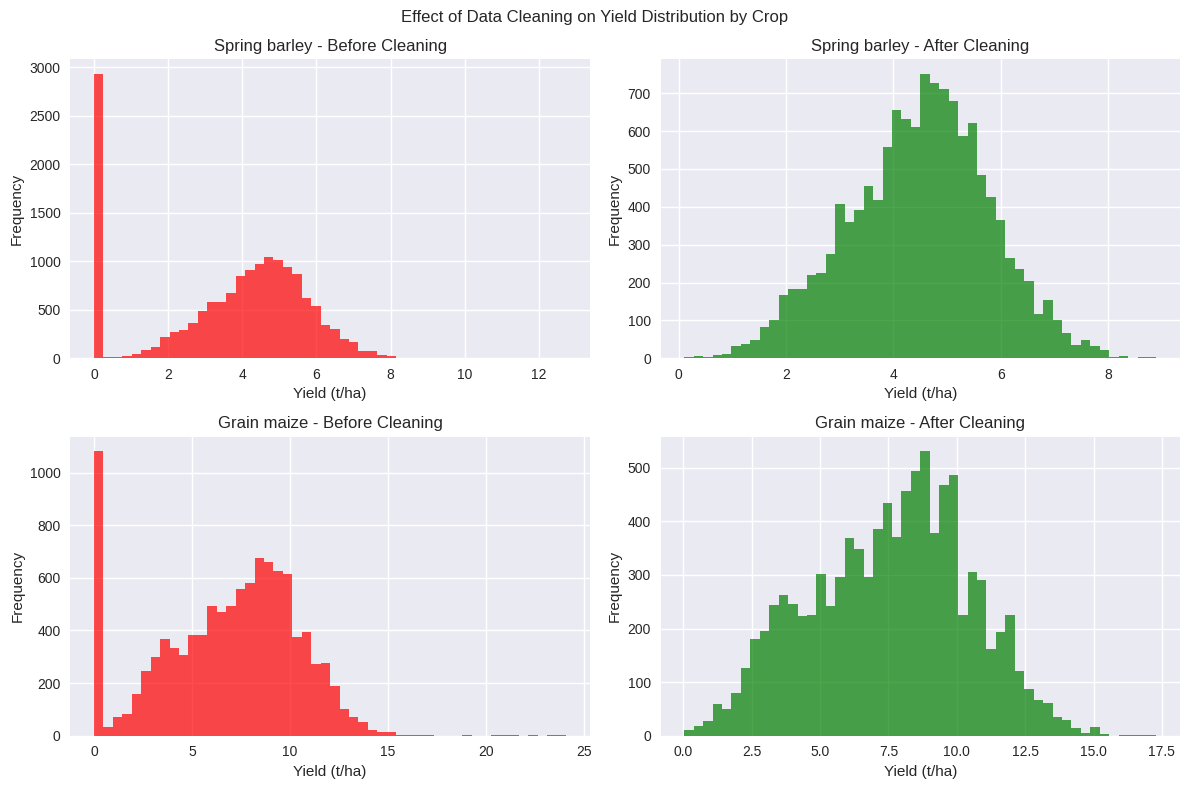

In [6]:
# Store original data size
original_size = len(yield_data)
print(f'📊 Original dataset size: {original_size} rows')

# Remove zero and negative values
zero_mask = yield_data['VALUE'] <= 0
zero_count = zero_mask.sum()
yield_data_clean = yield_data[~zero_mask].copy()

# Remove nan values
with_nan_size = len(yield_data_clean)
yield_data_clean = yield_data_clean.dropna(subset=['VALUE'])
wo_nan_size = len(yield_data_clean)

# Remove outliers using IQR method for each crop separately
def remove_outliers_iqr(df, column, group_by=None):
    """Remove outliers using the Interquartile Range (IQR) method"""
    if group_by:
        outlier_mask = pd.Series(False, index=df.index)
        for group in df[group_by].unique():
            group_data = df[df[group_by] == group][column]
            Q1 = group_data.quantile(0.25)
            Q3 = group_data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 2 * IQR
            upper_bound = Q3 + 2 * IQR
            group_outliers = (group_data < lower_bound) | (group_data > upper_bound)
            outlier_mask[group_data.index] = group_outliers
        return ~outlier_mask
    else:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 2 * IQR
        upper_bound = Q3 + 2 * IQR
        return (df[column] >= lower_bound) & (df[column] <= upper_bound)

# Apply outlier removal for each crop
outlier_mask = remove_outliers_iqr(yield_data_clean, 'VALUE', 'CROP_NAME')
outlier_count = (~outlier_mask).sum()
yield_data_clean = yield_data_clean[outlier_mask].copy()

print(f'❌ Removed:\n{zero_count} rows with zero and negative yield values\n{with_nan_size-wo_nan_size} rows with NaN values\n{outlier_count} outlier rows')
print(f'✅ Clean dataset size: {len(yield_data_clean)} rows')

crops = yield_data['CROP_NAME'].unique()

# Set up a 2x2 grid of subplots (2 crops x before/after)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i, crop in enumerate(crops):
    # Filter by crop for both dataframes
    yd_crop = yield_data[yield_data['CROP_NAME'] == crop]
    ydc_crop = yield_data_clean[yield_data_clean['CROP_NAME'] == crop]

    # Before cleaning
    yd_crop['VALUE'].hist(bins=50, alpha=0.7, ax=axes[i, 0], color='red')
    axes[i, 0].set_title(f'{crop} - Before Cleaning')
    axes[i, 0].set_xlabel('Yield (t/ha)')
    axes[i, 0].set_ylabel('Frequency')

    # After cleaning
    ydc_crop['VALUE'].hist(bins=50, alpha=0.7, ax=axes[i, 1], color='green')
    axes[i, 1].set_title(f'{crop} - After Cleaning')
    axes[i, 1].set_xlabel('Yield (t/ha)')
    axes[i, 1].set_ylabel('Frequency')

plt.suptitle('Effect of Data Cleaning on Yield Distribution by Crop')
plt.tight_layout()
plt.show()


# As a last step, lets reformat the yield data to NUTS2 regions to save computation power
yield_data_clean['IDREGION'] = yield_data_clean['IDREGION'].str[:4]
yield_data_clean = yield_data_clean.groupby(['IDREGION', 'CROP_NAME', 'VARIABLE', 'YEAR', 'COUNTRY'])['VALUE'].mean().reset_index()

Now that the data has been cleaned, we can have a look at the data in more detail. In the following part, we will compare the crop yields for the different countries and look at temporal trends.

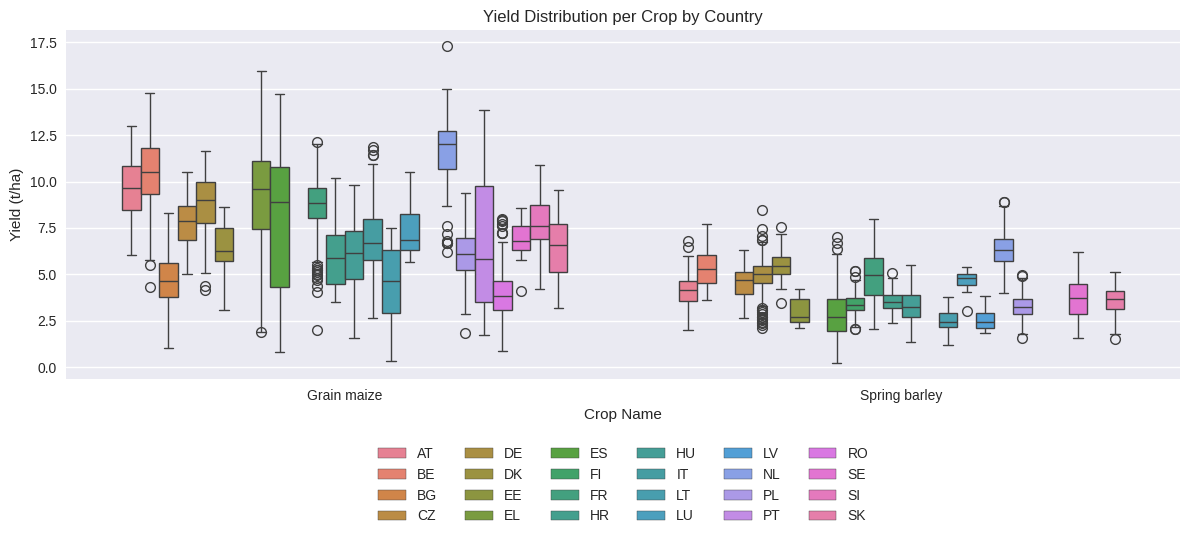

In [7]:
# Sort the DataFrame by COUNTRY
df_sorted = yield_data_clean.sort_values(by='COUNTRY')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_sorted, x='CROP_NAME', y='VALUE', hue='COUNTRY')

# Get handles and labels for legend, sort them alphabetically
handles, labels = plt.gca().get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda x: x[0]))

plt.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=len(labels)/4)
plt.title('Yield Distribution per Crop by Country')
plt.xlabel('Crop Name')
plt.ylabel('Yield (t/ha)')
plt.tight_layout()
plt.show()

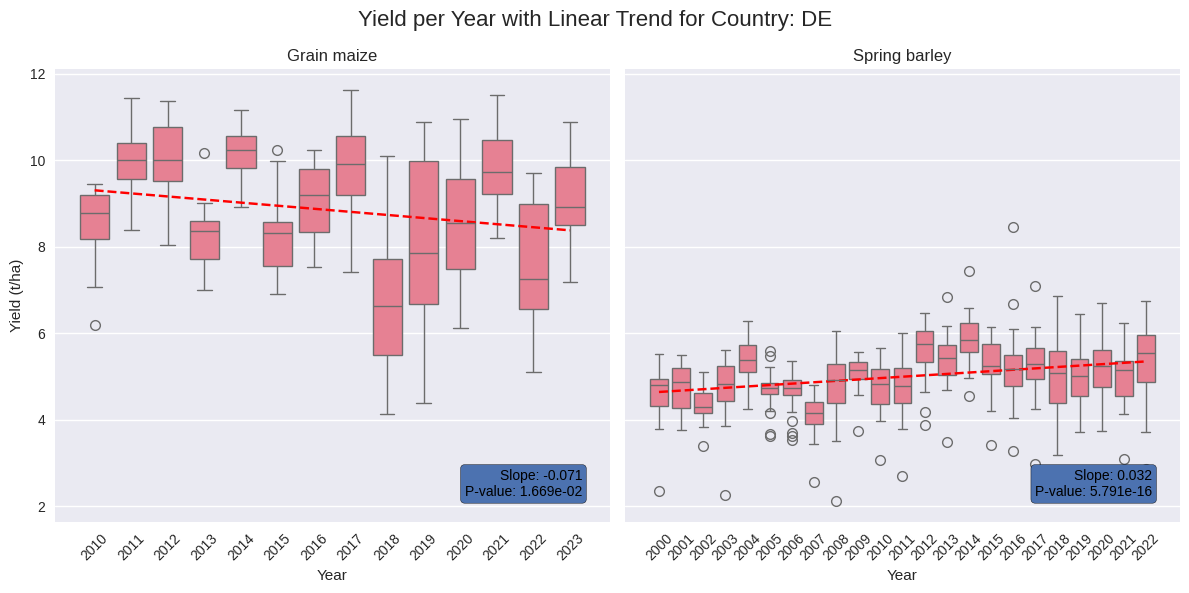

In [39]:
country = 'DE'  # Replace with your chosen country as above in the legend
df_country = yield_data_clean[yield_data_clean['COUNTRY'] == country]
crop_list = sorted(df_country['CROP_NAME'].unique())
n_crops = len(crop_list)

fig, axes = plt.subplots(1, n_crops, figsize=(6 * n_crops, 6), sharey=True)

for idx, crop in enumerate(crop_list):
    ax = axes[idx] if n_crops > 1 else axes

    df_crop = df_country[df_country['CROP_NAME'] == crop]
    sns.boxplot(data=df_crop, x='YEAR', y='VALUE', ax=ax)
    ax.set_title(crop)
    ax.set_xlabel('Year')
    ax.tick_params(axis='x', rotation=45)
    if idx == 0:
        ax.set_ylabel('Yield (t/ha)')
    else:
        ax.set_ylabel('')

    # Perform linear regression for trend line
    # Convert YEAR to numeric (if not already)
    x = df_crop['YEAR'].astype(int)
    y = df_crop['VALUE']

    # Set x-ticks to unique years, labels as year numbers (numeric)
    years = sorted(df_crop['YEAR'].unique())
    ax.set_xticks(range(len(years)))
    ax.set_xticklabels(years, rotation=45)

    # For linear regression x values, map years to positions 0,1,2...
    x_positions = [years.index(year) for year in x]
    slope, intercept, r_value, p_value, std_err = linregress(x_positions, y)
    x_vals = np.arange(len(years))
    y_vals = intercept + slope * x_vals

    # Plot trend line
    ax.plot(x_vals, y_vals, color='red', linestyle='--')

    # Annotate slope and significance
    annotation = f'Slope: {slope:.3f}\nP-value: {p_value:.3e}'
    ax.text(0.95, 0.05, annotation, transform=ax.transAxes,
            verticalalignment='bottom', horizontalalignment='right',
            fontsize=10, color='black', bbox=dict(boxstyle='round,pad=0.3', alpha=1.0))

plt.suptitle(f'Yield per Year with Linear Trend for Country: {country}', fontsize=16)
plt.tight_layout()
plt.show()

Now that we got to know the crop yield data, we need some predictors to forecast crop yields. Let's start with soil moisture which is a critical parameter for crop growth. As shown in the practical before the break, soil moisture can be accurately derived from satellite data. Here, we are using the ESA CCI Soil Moisture GAPFILLED dataset as produced and described by Preimesberger et al. (https://doi.org/10.5194/essd-17-4305-2025). The data is publicly available on https://researchdata.tuwien.ac.at/records/3fcxr-cde10 In addition to the predictor, we also need a shapefile which contains the regions that we want to model. This can be found on https://ec.europa.eu/eurostat/web/gisco/geodata/statistical-units/territorial-units-statistics. With this file, we extract the predictors such that we have the mean of all pixel values laying within the individual areas.

Before the extraction, let us have a look at the areas and the predictor datasets to get a feeling for the data.

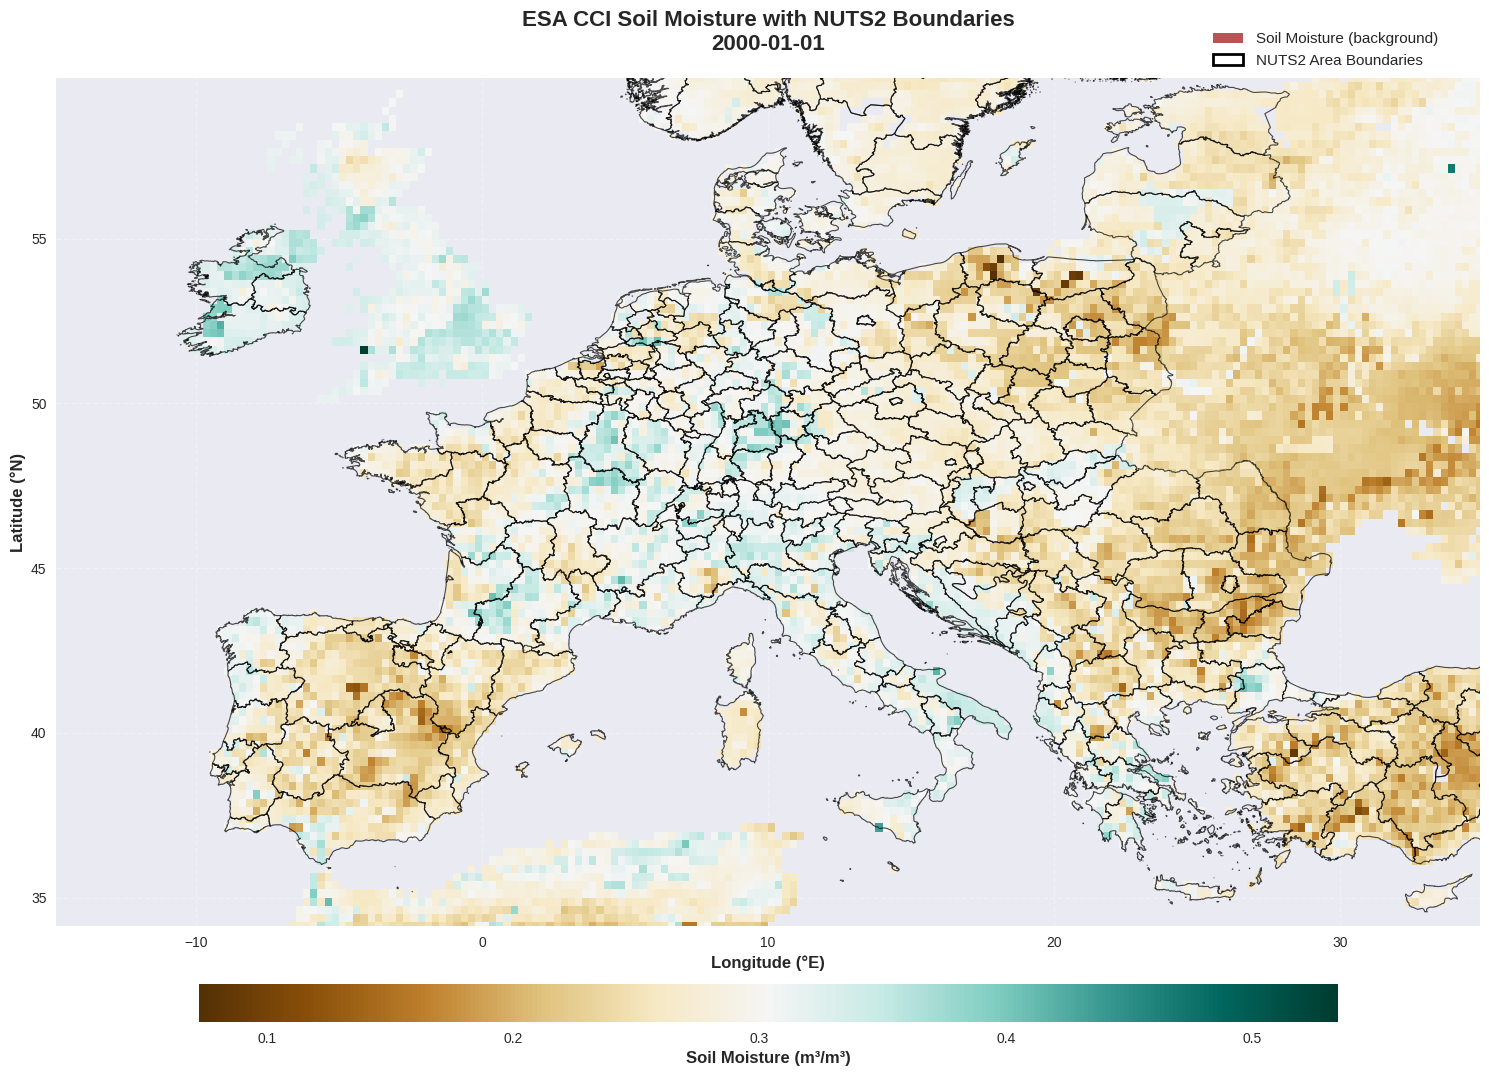


📊 Spatial Analysis Results:
   • NUTS2 areas plotted: 299
   • Soil moisture grid points: 20,800
   • Average soil moisture: 0.273


In [3]:
# Loading NUTS areas and select NUTS2
nuts_areas_gdf = gpd.read_file('data/NUTS_areas.shp')
nuts_areas = nuts_areas_gdf[nuts_areas_gdf['LEVL_CODE'] == 2].copy()

# Read soil moisture data
soil_moisture_ds = xr.open_dataset('data/sm.nc')

# Get the first time step from soil moisture data for visualization
first_date = soil_moisture_ds.time.values[0]
first_date_str = pd.Timestamp(first_date).strftime('%Y-%m-%d')

# Extract soil moisture data for the first date
sm_first_date = soil_moisture_ds.sel(time=first_date)['sm']

# Create the spatial visualization
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Plot soil moisture as background
im = sm_first_date.plot(
    ax=ax,
    cmap='BrBG',
    add_colorbar=False,  # We'll add a custom colorbar
    alpha=1,
    extend='both'
)

# Add colorbar for soil moisture
cbar = plt.colorbar(im, ax=ax, orientation='horizontal',
                   pad=0.05, shrink=0.8, aspect=30)
cbar.set_label('Soil Moisture (m³/m³)', fontsize=12, fontweight='bold')

# Plot NUTS3 boundaries on top
nuts_areas.plot(
    ax=ax,
    facecolor='none',  # Transparent fill
    edgecolor='black',   # Red boundaries
    linewidth=0.8,
    alpha=0.7
)

# Customize the plot
ax.set_title(f'ESA CCI Soil Moisture with NUTS2 Boundaries\n{first_date_str}',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Longitude (°E)', fontsize=12, fontweight='bold')
ax.set_ylabel('Latitude (°N)', fontsize=12, fontweight='bold')

# Set appropriate extent (focus on Europe)
if len(nuts_areas) > 0:
    bounds = nuts_areas.total_bounds
    lat_min, lat_max = soil_moisture_ds.lat.values.min(), soil_moisture_ds.lat.values.max()
    lon_min, lon_max = soil_moisture_ds.lon.values.min(), soil_moisture_ds.lon.values.max()
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)

# Add grid for better orientation
ax.grid(True, alpha=0.3, linestyle='--')

# Add legend
legend_elements = [
    Patch(facecolor='brown', alpha=0.8, label='Soil Moisture (background)'),
    Patch(facecolor='none', edgecolor='black', linewidth=2, label='NUTS2 Area Boundaries')
]
ax.legend(handles=legend_elements, loc='upper right',
          bbox_to_anchor=(0.98, 1.07), fontsize=11)

plt.tight_layout()
plt.show()

# Print some statistics about the spatial data
print(f"\n📊 Spatial Analysis Results:")
print(f"   • NUTS2 areas plotted: {len(nuts_areas)}")
print(f"   • Soil moisture grid points: {sm_first_date.size:,}")
print(f"   • Average soil moisture: {sm_first_date.mean().values:.3f}")

Starting extraction of sm data
Starting extraction of evi data
✅ All data extracted and saved as csv files
Available regions: ['AT11', 'AT33', 'AT34', 'BE22', 'BG34', 'BE23', 'BA01', 'BE24', 'BG41', 'BE25', 'BE31', 'BA02', 'BE32', 'BA03', 'BE10', 'BE21', 'BE33', 'BG42', 'BE34', 'BE35', 'AT12', 'AT21', 'BG31', 'AT22', 'AL01', 'BG32', 'AT31', 'AL02', 'AT32', 'AL03', 'BG33', 'EL63', 'EL41', 'DED4', 'DED5', 'EL42', 'EL64', 'DEE0', 'EL51', 'DEF0', 'EL65', 'DEA3', 'EL52', 'DK04', 'DEA4', 'DEG0', 'EL53', 'DEA5', 'DK01', 'DK05', 'EL54', 'DEB1', 'DEB2', 'DK02', 'EL61', 'DEB3', 'EE00', 'DEC0', 'EL62', 'DED2', 'DK03', 'EL30', 'DE92', 'DE24', 'CZ02', 'DE27', 'DE30', 'DE93', 'DE25', 'CZ03', 'DEA2', 'DE26', 'CZ04', 'DE40', 'DE50', 'DE60', 'DE94', 'DEA1', 'CH01', 'DE13', 'CZ05', 'DE71', 'DE72', 'CH02', 'DE14', 'CH03', 'CZ06', 'DE73', 'CH04', 'DE21', 'CZ07', 'CH05', 'CZ08', 'DE80', 'DE22', 'CH06', 'CH07', 'DE11', 'DE91', 'DE23', 'CZ01', 'DE12', 'FRB0', 'FRF1', 'FRE1', 'FRI1', 'FRF2', 'FRE2', 'FRI2', '

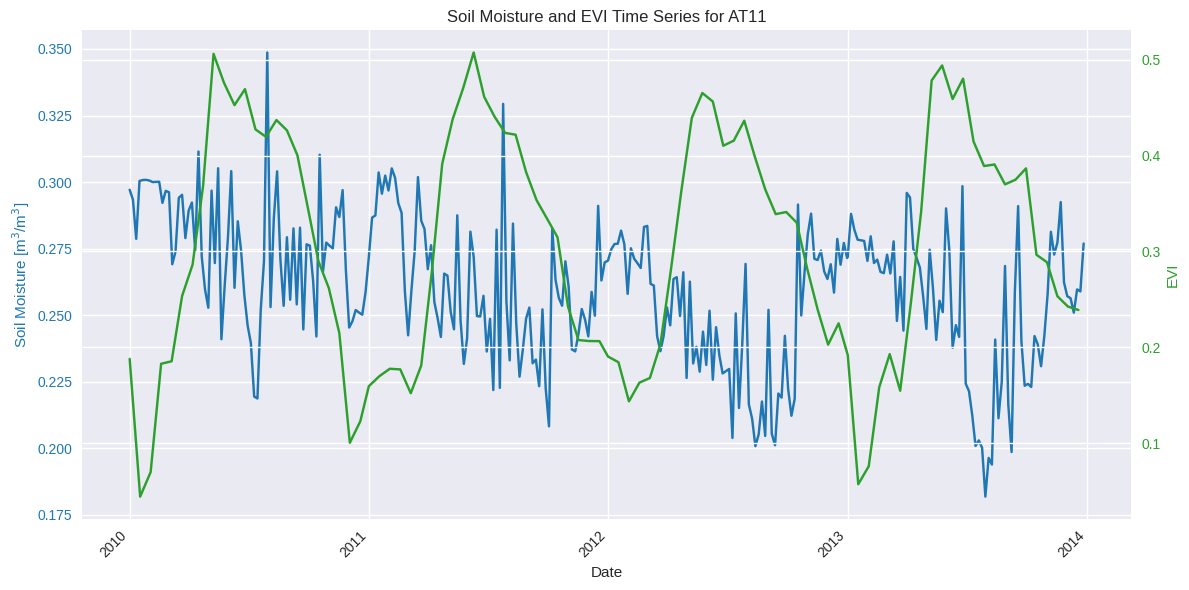

In [10]:
# 1. Read the shapefile, filter for LEVL_CODE == 2 -> NUTS2 areas
gdf = gpd.read_file("data/NUTS_areas.shp")
regions_nuts2 = gdf[gdf["LEVL_CODE"] == 2]
names_dict = {a:b for a,b in zip(regions_nuts2.index.tolist(), regions_nuts2.NUTS_ID.tolist())}
for dataset in ["sm", "evi"]:
    print(f"Starting extraction of {dataset} data")
    # 2. Read the NetCDF file
    ds = xr.open_dataset(f"data/{dataset}.nc")
    # 3. Create the regionmask
    reg_mask = regionmask.Regions(name="regions",
                                  numbers=regions_nuts2.index.tolist(),
                                  outlines=regions_nuts2.geometry.values,
                                  names=regions_nuts2["NUTS_ID"])
    mask = reg_mask.mask(ds)
    # 4. Calculate mean per region and time
    means = ds[dataset].groupby(mask).mean()  # replace "variable_name" with the variable in nc
    # 5. Convert to DataFrame and save as CSV
    df = means.to_dataframe().unstack(level=0)
    df.columns = df.columns.droplevel()
    df.index = [names_dict[int(a)] for a in df.index]   # Renames the indices to NUTS_ID instead if region number
    if dataset == "evi":
        df = df/100000000   # This step is required as the MODIS data uses a scalefactor on their dataset.
    df.to_csv(f"data/{dataset}_reg.csv")
print(f"✅ All data extracted and saved as csv files")

# Load your data
sm_df = pd.read_csv("data/sm_reg.csv", index_col=0)
evi_df = pd.read_csv("data/evi_reg.csv", index_col=0)
# Convert columns to datetime
sm_df.columns = pd.to_datetime(sm_df.columns)
evi_df.columns = pd.to_datetime(evi_df.columns)
# List of available regions
available_regions = sm_df.index.intersection(evi_df.index).tolist()
print("Available regions:", available_regions)
# Specify the region and time range to plot
region_to_plot = "AT11"
start_date = "2010-01-01"
end_date = "2013-12-31"
# Select region and time window
sm_series = sm_df.loc[region_to_plot]
evi_series = evi_df.loc[region_to_plot]
# Filter by date range
sm_series = sm_series[(sm_series.index >= start_date) & (sm_series.index <= end_date)]
evi_series = evi_series[(evi_series.index >= start_date) & (evi_series.index <= end_date)]

fig, ax1 = plt.subplots(figsize=(12,6))
color_sm = "tab:blue"
ax1.set_xlabel("Date")
ax1.set_ylabel(r"Soil Moisture [m$^3$/m$^3$]", color=color_sm)
ax1.plot(sm_series.index, sm_series.values, color=color_sm, label="Soil Moisture")
ax1.tick_params(axis="y", labelcolor=color_sm)

ax2 = ax1.twinx()
color_evi = "tab:green"
ax2.set_ylabel("EVI", color=color_evi)
ax2.plot(evi_series.index, evi_series.values, color=color_evi, label="EVI")
ax2.tick_params(axis="y", labelcolor=color_evi)

# Set x-axis ticks to yearly intervals at start of each year
years = mdates.YearLocator()
year_fmt = mdates.DateFormatter("%Y")
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(year_fmt)
fig.autofmt_xdate(rotation=45)

plt.title(f"Soil Moisture and EVI Time Series for {region_to_plot}")
plt.tight_layout()
plt.show()

We can see, that both datasets are already quite clean: no outliers nor gaps. In ML with EO data most time is usually spent to prepare the data, to smooth the timeseries, fill gaps etc. To not spend too much time on this during this practical, we focus on these two datasets.

Now, we want to reformate this data such that it is usable for a machine learning model. We do this by aggregating the timeseries to monthly timesteps. This decreases the uncertainties in the data and leaves us with a lower amount of predictors.

To do so, and to make all regions comparable, we select an approximate harvest date per country and start calculating back from this. I.e., maize harvesting season in Europe starts often beginning of September. Hence, the last month before harvest is beginning of 1-31 August. The second to last month is July and so on. We call these months now lead time 0 and 1 (LT0 and LT1). We extract the datasets now such that we have several values over the growing period starting with LT6. This will result in 14 predictors in total (2 datasets: sm and evi and for each dataset 7 timesteps).

Timeseries modelling: it is important to note here, that classical machine learning approaches cannot properly handle timeseries data. They take months as individual predictors but do not understand how they relate to each other. To make sense of the timeseries information deep learning models like Recurrent Neural Networks (e.g. Long Short-Term Memory) or Transformers are required. However, these require much more data for training than considered here and take longer for training. A common solution to tackle the issue of data requirements is transfer learning. This is beyond the goal of this practical. If you are interested check: https://dx.doi.org/10.2139/ssrn.5108346

For further good practices in machine learning check: https://doi.org/10.1021/acs.est.3c00026

In [11]:
# Take sm and evi data from above and aggregate to monthly means
sm_df_monthly = sm_df.resample('M', axis=1).mean()
evi_df_monthly = evi_df.resample('M', axis=1).mean()

# Define start of the harvesting season, which is in Europe generally:
# Spring Barley ~ July (7)
# Maize ~ September (9)
harvest_months = {
    'spring barley': 7,
    'maize': 9
}

# Map region prefix to continent or country grouping if needed (not specified, so use fixed harvest months)
# Initialize containers for each crop type
crop_types = yield_data_clean['CROP_NAME'].unique()

# Process each crop type separately
for crop in crop_types:
    subset = yield_data_clean[yield_data_clean['CROP_NAME'] == crop].copy()

    data_records = []

    for idx, row in subset.iterrows():
        region = row['IDREGION']
        year = row['YEAR']
        yield_val = row['VALUE']
        crop_lower = crop.lower()

        # Determine harvest month for this crop (could extend by country if info is available)
        harvest_month = harvest_months.get(crop_lower, 7)
        harvest_date = pd.Timestamp(year=year, month=harvest_month, day=1) + pd.offsets.MonthEnd(0)

        # Prepare dict for output row
        output_row = {
            'IDREGION': region,
            'YEAR': year,
            'CROP_NAME': crop,
            'VALUE': yield_val
        }

        # For LT0 to LT6 lead times, get monthly aggregated predictor values
        for lt in range(7):
            # month for this lead time is harvest month minus LT months
            predictor_month = harvest_date - pd.DateOffset(months=lt)

            # Get month key matching the monthly aggregated predictor columns (end of month)
            month_key = predictor_month

            # For the given region, get the predictors for that month, fallback to NaN if missing
            sm_val = np.nan
            evi_val = np.nan
            try:
                sm_val = sm_df_monthly.at[region, month_key]
            except KeyError:
                pass
            try:
                evi_val = evi_df_monthly.at[region, month_key]
            except KeyError:
                pass

            output_row[f'sm_LT{lt}'] = sm_val
            output_row[f'evi_LT{lt}'] = evi_val

        data_records.append(output_row)

    # Create DataFrame for this crop type
    crop_out_df = pd.DataFrame.from_records(data_records)

    # Save to CSV
    output_filename = f'data/yield_predictors_{crop.lower().replace(" ", "_")}.csv'
    crop_out_df = crop_out_df.dropna(axis=0, how='any')
    crop_out_df.to_csv(output_filename, index=False)

    print(f'Saved {output_filename}')

Saved data/yield_predictors_grain_maize.csv
Saved data/yield_predictors_spring_barley.csv


Now that the predictor files are ready, we can start with the modelling... For the start we will just use an Extreme Gradient Boosting approach, which is one of the most commonly used approaches for crop yield modelling using EO data. As shown in the lecture in the morning, there are many more that could be used. And later here, we will use some more models. For the full list of all ML models provided by the Python library scikit learn check: https://scikit-learn.org/stable/supervised_learning.html Of course, recently the has been towards more deep learning approaches like all kind of Neural Networks (Artificial, Convolutional, Recurrent...), Gated Recurrent Units, Generative Adversarial Networks, up to Transformers. However, due to computational and data constrains, we will stick to the classical machine learning approaches here. If you are interested about deep learning then check the Pytorch, Keras, and Tensorflow packages. 

In [12]:
# First, define the crop you want to model, the lead times and the validation metric
crop = "spring_barley"  # Choose from grain_maize and spring_barley
lead_times = [0, 2, 4]  # Months before harvest season, choose from 0 to 6
metric = "r2"           # Choose from explained_variance, r2, neg_mean_absolute_percentage_error

path = f'data/yield_predictors_{crop}.csv'
file = pd.read_csv(path)

# Dictionary to store results for each lead time
results_dict = {}
scores_list = []
lead_time_labels = []

# Loop through each lead time
for lead_time in lead_times:
    print(f"Processing lead time: {lead_time}")

    # Get predictors for current lead time
    predictors = [col for col in file.columns if col[-3:-1]=="LT"]
    used_predictors = [a for a in predictors if int(a[-1]) >= lead_time]

    # Prepare data
    X = file.loc[:, used_predictors]
    years = file.loc[:, 'YEAR']
    regs = file.loc[:, 'IDREGION']

    X.index = pd.to_datetime(years.values, format="%Y")
    y = file.loc[:, 'VALUE']

    # Define model and pipeline
    estimator = xgb.XGBRegressor(
        max_depth=3,
        learning_rate=0.1,
        n_estimators=100,
        random_state=42  # Added for reproducibility
    )
    pipe_xgb = Pipeline([('scalar', StandardScaler()), ('clf', estimator)])

    # Cross-validation
    groups = years
    logo = LeaveOneGroupOut()

    scores = cross_validate(pipe_xgb, X, y, cv=logo, groups=groups, scoring=metric,
                           n_jobs=30, return_train_score=False)['test_score']

    # Store results
    results_dict[f'Lead Time {lead_time}'] = scores

    # Prepare data for boxplot
    scores_list.extend(scores)
    lead_time_labels.extend([f'LT {lead_time}'] * len(scores))

    print(f"Lead time {lead_time}: Mean score = {scores.mean():.4f}, Std = {scores.std():.4f}")

# Create DataFrame for plotting
plot_data = pd.DataFrame({
    'Lead Time': lead_time_labels,
    'Explained Variance': scores_list
})

Processing lead time: 0
Lead time 0: Mean score = 0.4886, Std = 0.1809
Processing lead time: 2
Lead time 2: Mean score = 0.3382, Std = 0.2330
Processing lead time: 4
Lead time 4: Mean score = 0.1966, Std = 0.1830


For better analysis lets make a plot of the results:

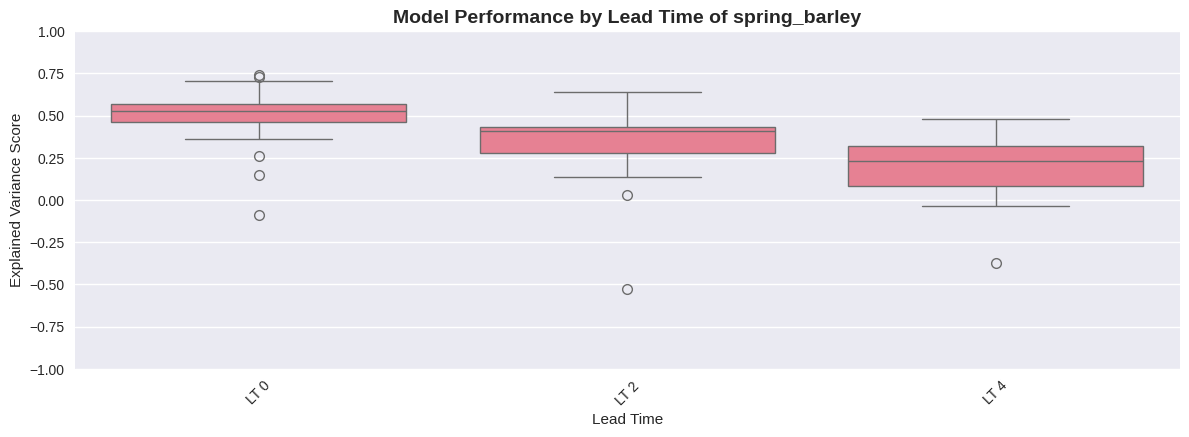

In [13]:
# Create the boxplot
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 2)
sns.boxplot(data=plot_data, x='Lead Time', y='Explained Variance')
plt.title(f'Model Performance by Lead Time of {crop}', fontsize=14, fontweight='bold')
plt.xlabel('Lead Time')
plt.ylabel('Explained Variance Score')
plt.xticks(rotation=45)

# Since there are some outliers, lets zoom in to R² range from -1 to 1 by uncommenting the following function:
plt.ylim(-1, 1)

plt.tight_layout()
plt.show()

Well done! You just did your (first?) crop yield forecast for most of Europe! Lets have a look at the forecasts and how they differ from observed yields.

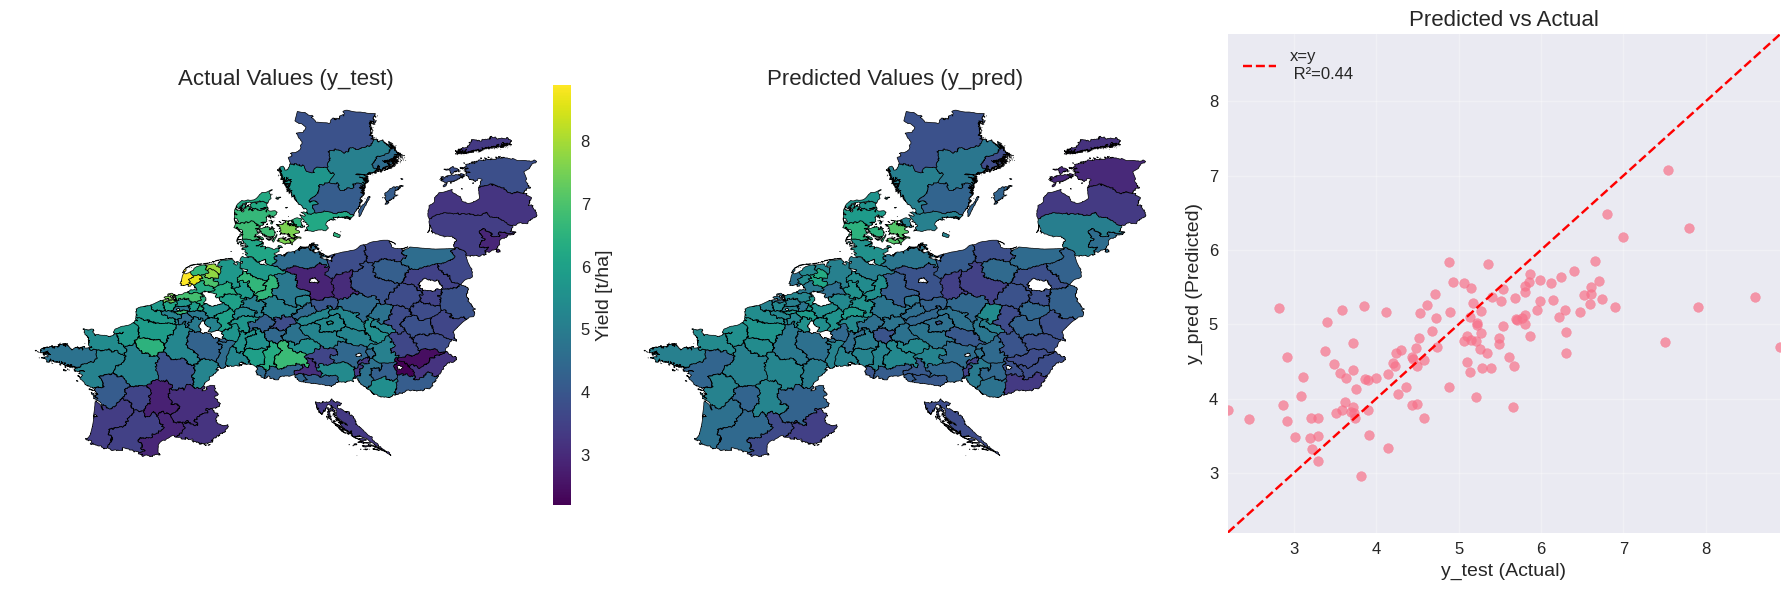

In [14]:
lead_time = 0          # For the visualisation, we focus on the last lead time. But you can also adjust this with a value from 0-6

# Get predictors for current lead time
predictors = [col for col in file.columns if col[-3:-1]=="LT"]
used_predictors = [a for a in predictors if int(a[-1]) >= lead_time]

# Lets make a forecast for the latest year in the dataset 2022
# Thus, we split the data into training (years before 2022) and testing (year 2022)
test_ind = np.where(file.loc[:, 'YEAR']==2022)[0]
train_ind = np.where(file.loc[:, 'YEAR']!=2022)[0]

# Prepare data
X_train, X_test = file.loc[train_ind, used_predictors], file.loc[test_ind, used_predictors]
y_train, y_test = file.loc[train_ind, 'VALUE'], file.loc[test_ind, 'VALUE']
regs = file.loc[test_ind, 'IDREGION']

# Define model and pipeline
estimator = xgb.XGBRegressor(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42  # Added for reproducibility
)
pipe_xgb = Pipeline([('scalar', StandardScaler()), ('clf', estimator)])
pipe_xgb.fit(X_train, y_train)
y_pred = pipe_xgb.predict(X_test)

data_df = pd.DataFrame({
    'region_name': regs,
    'y_test': y_test,
    'y_pred': y_pred
})

# Merge the shapefile with your data
# Replace 'REGION_NAME_COLUMN' with the actual column name in your shapefile that contains region names
gdf_merged = nuts_areas.merge(data_df, left_on='NUTS_ID', right_on='region_name', how='left')

# Calculate shared colorbar range
vmin = min(min(y_test), min(y_pred))
vmax = max(max(y_test), max(y_pred))
norm = Normalize(vmin=vmin, vmax=vmax)

# Create the three plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Spatial plot colored by y_test
gdf_merged.plot(column='y_test',
                ax=axes[0],
                cmap='viridis',
                vmin=vmin,
                vmax=vmax,
                edgecolor='black',
                linewidth=0.5)
axes[0].set_title('Actual Values (y_test)', fontsize=16)
axes[0].axis('off')

# Plot 2: Spatial plot colored by y_pred
gdf_merged.plot(column='y_pred',
                ax=axes[1],
                cmap='viridis',
                vmin=vmin,
                vmax=vmax,
                edgecolor='black',
                linewidth=0.5)
axes[1].set_title('Predicted Values (y_pred)', fontsize=16)
axes[1].axis('off')

# Add colorbar between first two plots
sm = cm.ScalarMappable(norm=norm, cmap='viridis')
sm.set_array([])
# Position the colorbar between axes[0] and axes[1]
cbar_ax = fig.add_axes([0.31, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Yield [t/ha]', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Plot 3: Scatterplot with x=y line
axes[2].scatter(y_test, y_pred, alpha=0.7)
axes[2].set_xlabel('y_test (Actual)', fontsize=14)
axes[2].set_ylabel('y_pred (Predicted)', fontsize=14)
axes[2].set_title('Predicted vs Actual', fontsize=16)
axes[2].tick_params(labelsize=12)

# Add x=y line
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
initial_perf = np.round(r2_score(y_test, y_pred),2)
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', label=f'x=y\n R²={initial_perf}')
axes[2].set_xlim(min_val, max_val)
axes[2].set_ylim(min_val, max_val)
axes[2].legend(fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Nice, the model ran smoothly, but we can see that the model is not really optimal yet. Usually the model can be further improved by different means:
 * Model selection
 * Hyperparameter-tuning
 * Feature selection
 * Data cleaning/preparation (anomaly calculation, adjust outlier removal, detrending)
 * Add more information as predictors, like year, country, latitude...
 * Remove data from training (regions with high uncertainties, split area into areas that are more "alike")
 * ...

For the sake of time, we are going to focus on the first three points only. Lets start with model selection. In this example we are using three classical ML approaches. Feel free to check out other models from sklearn and simply replace the models that are used now in the following code.


==================== XGBoost ====================
Processing XGBoost with lead time: 0
Training years: 2001 - 2018 (18 years)
Testing years: 2019 - 2023 (5 years)
Training samples: 2500
Testing samples: 594
  Mean score = 0.5156, Std = 0.1787
Processing XGBoost with lead time: 1
Training years: 2001 - 2018 (18 years)
Testing years: 2019 - 2023 (5 years)
Training samples: 2500
Testing samples: 594
  Mean score = 0.4823, Std = 0.1938

==================== SVM ====================
Processing SVM with lead time: 0
Training years: 2001 - 2018 (18 years)
Testing years: 2019 - 2023 (5 years)
Training samples: 2500
Testing samples: 594
  Mean score = 0.5552, Std = 0.1887
Processing SVM with lead time: 1
Training years: 2001 - 2018 (18 years)
Testing years: 2019 - 2023 (5 years)
Training samples: 2500
Testing samples: 594
  Mean score = 0.4872, Std = 0.1844

==================== MLP ====================
Processing MLP with lead time: 0
Training years: 2001 - 2018 (18 years)
Testing years: 2019

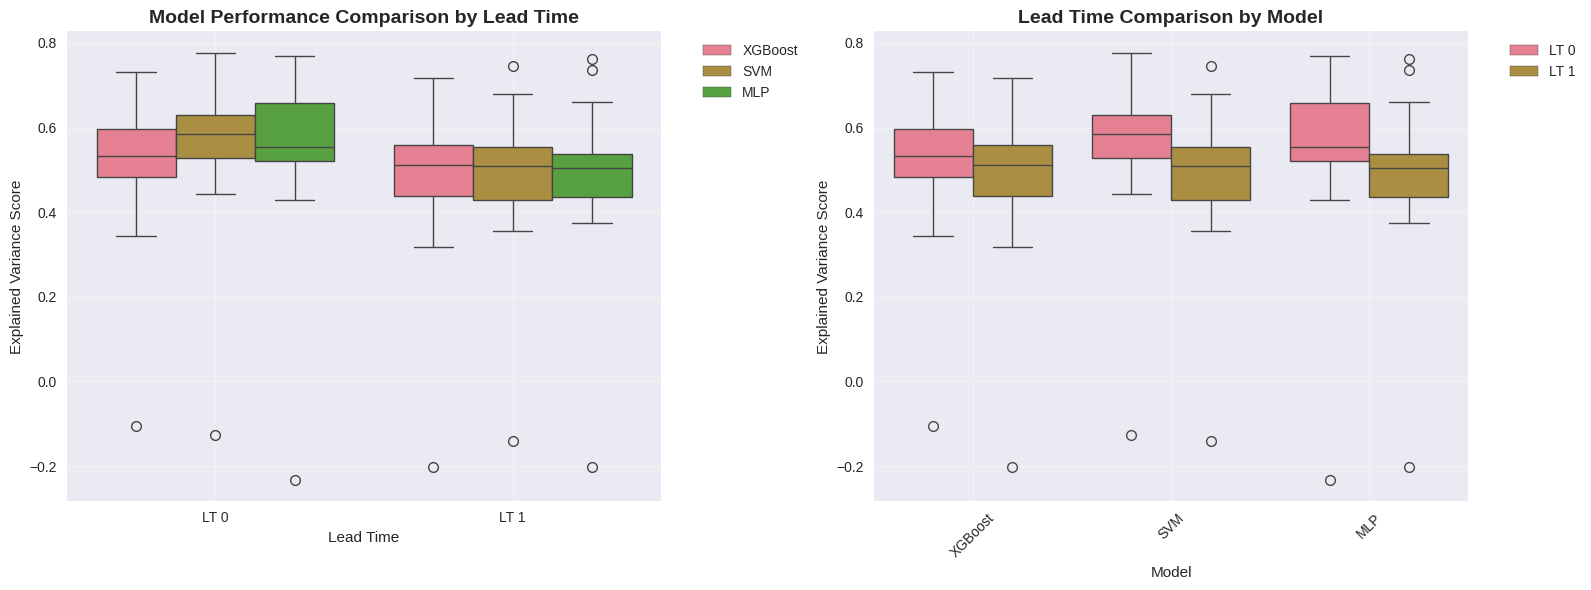

In [15]:
# Before validating different models, we need to make another subsplit of the data. So far we have just used train and test data, but now, we also need a validation split. For this we retain the last 20% of the years for testing only. This step is done in the following function.

def train_test_split(file, lead_time, print_shape=False):
    # Get predictors for current lead time
    predictors = [col for col in file.columns if col[-3:-1]=="LT"]
    used_predictors = [a for a in predictors if int(a[-1]) >= lead_time]

    # Prepare data
    X = file.loc[:, used_predictors]
    years = file.loc[:, 'YEAR']

    X.index = pd.to_datetime(years.values, format="%Y")
    y = file.loc[:, 'VALUE']

    # Remove test years from validation:
    # Split data into training (first 80%) and testing (last 20%) based on years
    unique_years = sorted(years.unique())
    train_cutoff = int(len(unique_years) * 0.8)
    train_years = unique_years[:train_cutoff]
    test_years = unique_years[train_cutoff:]

    # Create train/test splits
    train_mask = years.isin(train_years)
    train_mask = np.where(train_mask==True)[0]
    test_mask = years.isin(test_years)
    test_mask = np.where(test_mask==True)[0]

    X_train = X.iloc[train_mask, :]
    y_train = y.iloc[train_mask]
    years_train = years[train_mask]

    X_test = X.iloc[test_mask, :]
    y_test = y.iloc[test_mask]
    years_test = years[test_mask]
    if print_shape:
        print(f"Training years: {min(train_years)} - {max(train_years)} ({len(train_years)} years)")
        print(f"Testing years: {min(test_years)} - {max(test_years)} ({len(test_years)} years)")
        print(f"Training samples: {X_train.shape[0]}")
        print(f"Testing samples: {X_test.shape[0]}")

    return X_train, X_test, y_train, y_test, years_train, years_test

# Define models to compare
lead_times = [0, 1]  # For now, we focus on the latest two lead-times to save computing power.

models = {
    'XGBoost': xgb.XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    ),
    'SVM': SVR(
        kernel='rbf',
        C=1.0,
        gamma='scale'
    ),
    # 'Ridge': Ridge(),
    'MLP': MLPRegressor(
        hidden_layer_sizes=(100,),
        activation='relu',
        learning_rate='constant',
    )
}

# Lists to store results for plotting
scores_list = []
lead_time_labels = []
model_labels = []

# Dictionary to store detailed results
results_dict = {}

# Loop through each model and lead time
for model_name, estimator in models.items():
    print(f"\n{'='*20} {model_name} {'='*20}")

    for lead_time in lead_times:
        print(f"Processing {model_name} with lead time: {lead_time}")

        X_train, X_test, y_train, y_test, years_train, years_test = train_test_split(file, lead_time, print_shape=True)

        # Create pipeline
        pipeline = Pipeline([('scalar', StandardScaler()), ('clf', estimator)])

        # Cross-validation
        groups = years_train
        logo = LeaveOneGroupOut()
        metric = "r2"

        scores = cross_validate(pipeline, X_train, y_train, cv=logo, groups=groups, scoring=metric,
                               return_train_score=False)['test_score']

        # Store results for plotting
        scores_list.extend(scores)
        lead_time_labels.extend([f'LT {lead_time}'] * len(scores))
        model_labels.extend([model_name] * len(scores))

        # Store detailed results
        key = f'{model_name}_LT_{lead_time}'
        results_dict[key] = scores

        print(f"  Mean score = {scores.mean():.4f}, Std = {scores.std():.4f}")

# Create DataFrame for plotting
plot_data = pd.DataFrame({
    'Lead Time': lead_time_labels,
    'Model': model_labels,
    'Explained Variance': scores_list
})

# Create the comparison plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Boxplot comparing models across lead times
sns.boxplot(data=plot_data, x='Lead Time', y='Explained Variance', hue='Model', ax=ax1)
ax1.set_title('Model Performance Comparison by Lead Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Lead Time')
ax1.set_ylabel('Explained Variance Score')
ax1.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Boxplot comparing lead times across models
sns.boxplot(data=plot_data, x='Model', y='Explained Variance', hue='Lead Time', ax=ax2)
ax2.set_title('Lead Time Comparison by Model', fontsize=14, fontweight='bold')
ax2.set_xlabel('Model')
ax2.set_ylabel('Explained Variance Score')
ax2.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

As a next step, we will do feature selection, which can further improve the performance and decrease the computing time. There are many different ways to define the best predictors. Here we will focus on 3 ways to do so:

1) Variance Threshold - This method removes features that have low variance across samples. Features with very low variance are likely to be constant or quasi-constant, meaning they provide little information for distinguishing between different outcomes. If a feature has the same or nearly the same value for most samples, it won't be useful for prediction. The method calculates the variance of each feature and removes those below a threshold.
2) Mutual Information Selection - Mutual Information measures the amount of information that knowing the value of one variable gives about another variable. Unlike correlation, it can capture non-linear relationships between features and the target. MI calculates how much uncertainty in the target variable is reduced by knowing a feature's value. Higher MI scores indicate that the feature provides more information about the target, making it more valuable for prediction.
3) Recursive Feature Elimination - RFE is a wrapper method that works by recursively training a model and eliminating the least important features. It starts with all features, trains an XGBoost model, ranks features by importance, removes the least important feature(s), and repeats until the desired number of features remains. This process ensures that feature interactions are considered, as the model evaluates features in combination rather than individually. XGBoost is particularly good at capturing complex patterns and feature interactions.


🔍 Feature Selection and Elimination
--------------------------------------------------
🔄 Starting with 14 features...

📈 Method 1: Variance Threshold
Removes features with low variance (constant/quasi-constant values)
✅ Kept: 14 features

🔗 Method 2: Mutual Information
Captures non-linear relationships between features and target
✅ Selected: 10 features
📊 Top 5 features by MI-score:
feature  mi_score
evi_LT3  0.234976
evi_LT1  0.193436
evi_LT2  0.180469
evi_LT0  0.142834
evi_LT4  0.126797

🔄 Method 3: RFE with XGBoost
Iterative selection considering feature interactions using XGBoost
✅ Selected: 8 features
📊 RFE selected features: ['sm_LT1', 'evi_LT1', 'evi_LT2', 'evi_LT3', 'evi_LT4', 'sm_LT5', 'evi_LT5', 'evi_LT6']

🤝 Consensus Feature Selection
📊 Consensus features: 11
✅ Features: ['evi_LT6', 'evi_LT5', 'evi_LT4', 'evi_LT3', 'sm_LT1', 'sm_LT0', 'evi_LT2', 'sm_LT6', 'evi_LT0', 'sm_LT5', 'evi_LT1']

📈 Creating visualization...


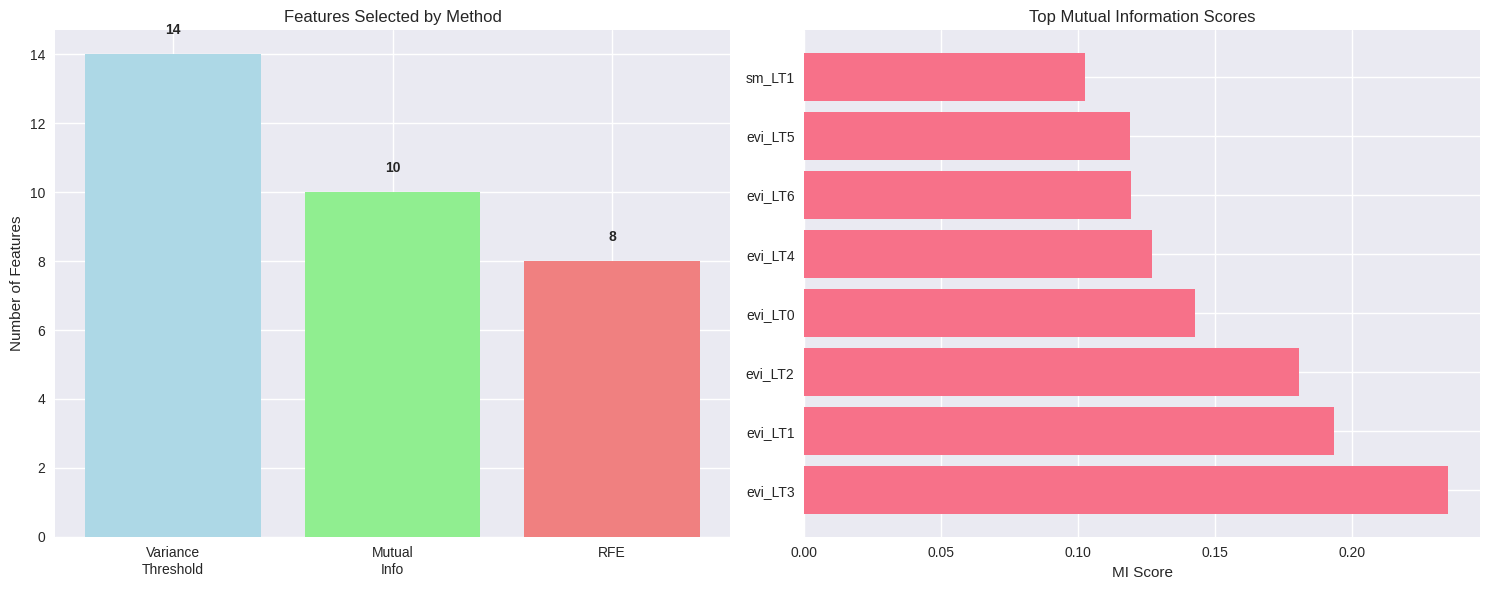


🎯 FINAL FEATURE SELECTION RESULTS:
   • Original features: 14
   • Selected features: 11
   • Reduction: 21.4%
   • Method used: Consensus
   • Final features: ['evi_LT6', 'evi_LT5', 'evi_LT4', 'evi_LT3', 'sm_LT1', 'sm_LT0', 'evi_LT2', 'sm_LT6', 'evi_LT0', 'sm_LT5', 'evi_LT1']


In [17]:
# ============================================================================
# FEATURE SELECTION AND ELIMINATION
# ============================================================================

X_train, X_test, y_train, y_test, years_train, years_test = train_test_split(file, lead_time=0)

print(f"\n🔍 Feature Selection and Elimination")
print("-" * 50)

print(f"🔄 Starting with {X_train.shape[1]} features...")
original_features = X_train.columns.tolist()

# ============================================================================
# METHOD 1: VARIANCE THRESHOLD
# ============================================================================

print(f"\n📈 Method 1: Variance Threshold")
print("Removes features with low variance (constant/quasi-constant values)")
variance_threshold = 0.0005
var_selector = VarianceThreshold(threshold=variance_threshold)
X_train_var = var_selector.fit_transform(X_train)
X_test_var = var_selector.transform(X_test)

selected_var_features = X_train.columns[var_selector.get_support()].tolist()
print(f"✅ Kept: {len(selected_var_features)} features")

# ============================================================================
# METHOD 2: MUTUAL INFORMATION
# ============================================================================

print(f"\n🔗 Method 2: Mutual Information")
print("Captures non-linear relationships between features and target")

k_best = min(10, X_train_var.shape[1])
mi_selector = SelectKBest(score_func=mutual_info_regression, k=k_best)
X_train_mi = mi_selector.fit_transform(X_train_var, y_train)
X_test_mi = mi_selector.transform(X_test_var)

mi_scores = mi_selector.scores_
selected_mi_indices = mi_selector.get_support(indices=True)
selected_mi_features = [selected_var_features[i] for i in selected_mi_indices]

print(f"✅ Selected: {len(selected_mi_features)} features")

# Display top features
mi_scores_df = pd.DataFrame({
    'feature': selected_var_features,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

print(f"📊 Top 5 features by MI-score:")
print(mi_scores_df.head(5)[['feature', 'mi_score']].to_string(index=False))

# ============================================================================
# METHOD 3: RECURSIVE FEATURE ELIMINATION WITH XGBoost
# ============================================================================

print(f"\n🔄 Method 3: RFE with XGBoost")
print("Iterative selection considering feature interactions using XGBoost")

rfe_estimator = xgb.XGBRegressor(
    n_estimators=50,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
n_features_rfe = min(8, X_train_var.shape[1])

rfe_selector = RFE(estimator=rfe_estimator, n_features_to_select=n_features_rfe, step=1)
X_train_rfe = rfe_selector.fit_transform(X_train_var, y_train)
X_test_rfe = rfe_selector.transform(X_test_var)

selected_rfe_indices = rfe_selector.get_support(indices=True)
selected_rfe_features = [selected_var_features[i] for i in selected_rfe_indices]

print(f"✅ Selected: {len(selected_rfe_features)} features")
print(f"📊 RFE selected features: {selected_rfe_features}")

# ============================================================================
# CONSENSUS FEATURE SELECTION
# ============================================================================

print(f"\n🤝 Consensus Feature Selection")

# Find features selected by multiple methods
all_methods_features = {
    'Variance Threshold': set(selected_var_features),
    'Mutual Info': set(selected_mi_features),
    'RFE': set(selected_rfe_features)
}

feature_counts = {}
for method_features in all_methods_features.values():
    for feature in method_features:
        feature_counts[feature] = feature_counts.get(feature, 0) + 1

# Find consensus features (selected by ≥2 methods)
consensus_threshold = 2
consensus_features = [feature for feature, count in feature_counts.items()
                     if count >= consensus_threshold]

if consensus_features:
    final_selected_features = consensus_features
    consensus_indices = [original_features.index(f) for f in consensus_features]
    X_train_selected = X_train.iloc[:, consensus_indices]
    X_test_selected = X_test.iloc[:, consensus_indices]
    print(f"📊 Consensus features: {len(consensus_features)}")
    print(f"✅ Features: {consensus_features}")
else:
    # Fallback to RFE selection
    final_selected_features = selected_rfe_features
    X_train_selected = pd.DataFrame(X_train_rfe, columns=selected_rfe_features, index=X_train.index)
    X_test_selected = pd.DataFrame(X_test_rfe, columns=selected_rfe_features, index=X_test.index)
    print(f"📊 No consensus found, using RFE selection")

# ============================================================================
# VISUALIZATION
# ============================================================================

print(f"\n📈 Creating visualization...")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Method comparison
methods = ['Variance\nThreshold', 'Mutual\nInfo', 'RFE']
n_selected = [len(selected_var_features), len(selected_mi_features), len(selected_rfe_features)]

bars = axes[0].bar(methods, n_selected, color=['lightblue', 'lightgreen', 'lightcoral'])
axes[0].set_title('Features Selected by Method')
axes[0].set_ylabel('Number of Features')

for i, count in enumerate(n_selected):
    axes[0].text(i, count + 0.5, f'{count}', ha='center', va='bottom', fontweight='bold')

# 2. Top MI scores
top_mi = mi_scores_df.head(8)
axes[1].barh(range(len(top_mi)), top_mi['mi_score'])
axes[1].set_yticks(range(len(top_mi)))
axes[1].set_yticklabels([f[:15] + '...' if len(f) > 15 else f for f in top_mi['feature']])
axes[1].set_title('Top Mutual Information Scores')
axes[1].set_xlabel('MI Score')

plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY
# ============================================================================

print(f"\n🎯 FINAL FEATURE SELECTION RESULTS:")
print(f"   • Original features: {len(original_features)}")
print(f"   • Selected features: {len(final_selected_features)}")
print(f"   • Reduction: {(1-len(final_selected_features)/len(original_features))*100:.1f}%")
print(f"   • Method used: {'Consensus' if consensus_features else 'RFE'}")
print(f"   • Final features: {final_selected_features}")

Having a model with less predictors helps to decrease computational time. However, did it also help to improve the performance?

In [18]:
main_columns = ['IDREGION', 'YEAR', 'CROP_NAME', 'VALUE']
all_columns = file.columns.tolist()
feature_columns = [col for col in all_columns if col not in main_columns]

#Or you can also do your own selection of predictors just select some of the predictors from the following list:
# final_selected_features = ['sm_LT0', 'evi_LT0', 'sm_LT1', 'evi_LT1', 'sm_LT2', 'evi_LT2', 'sm_LT3', 'evi_LT3', 'sm_LT4', 'evi_LT4', 'sm_LT5', 'evi_LT5', 'sm_LT6', 'evi_LT6']

columns_to_keep = main_columns + final_selected_features

# Filter dataframe
file_filtered = file[columns_to_keep].copy()

# Prepare data
X_train_fe, X_test_fe, y_train_fe, y_test_fe, years_train_fe, years_test_fe = train_test_split(file_filtered, lead_time)
X_train, X_test, y_train, y_test, years_train, years_test = train_test_split(file, lead_time)

# Create pipeline
pipeline = Pipeline([('scalar', StandardScaler()), ('clf', estimator)])

# Cross-validation
groups = years_train
logo = LeaveOneGroupOut()
metric = "r2"

scores_fe = cross_validate(pipeline, X_train_fe, y_train_fe, cv=logo, groups=groups, scoring=metric, return_train_score=False)['test_score']
scores = cross_validate(pipeline, X_train, y_train, cv=logo, groups=groups, scoring=metric, return_train_score=False)['test_score']

print(f'R² of the original features: {np.mean(scores).round(2)} and after feature elimination: {np.mean(scores_fe).round(2)}\n change in performance before and after feature elimination: {np.round(np.mean(scores_fe)-np.mean(scores),2)}')

R² of the original features: 0.49 and after feature elimination: 0.48
 change in performance before and after feature elimination: -0.0


Perfect, so now we will focus on the best model and try to further optimize it using hyperparameter tuning. The hyperparameters of a model define the structure of the model. For example the tree based algorithms XGB and random forest, there are hyperparameters like n_estimators which are the numer of decision trees that are used (often is somewhere between from 50 to 500) and max_depth which describes the maximum depth per decision trees (i.e. how many levels of decisions are done. This often ranges form 5 to 50). For each model there are dozens of hyperparameters. However, here, we just focus on the 2-3 most important ones.

In [19]:
# Choose your model: "xgboost", "svm", "mlp"
MODEL = "xgboost"

# Choose your lead time
lead_time = 0

feature_elimination = True  # Should we use the feature elimination or should we do the hp tuning on all features?

# =============================================================================
# HYPERPARAMETER TUNING ANALYSIS
# =============================================================================

print("="*70)
print(f"HYPERPARAMETER TUNING: {MODEL.upper()} - Lead Time {lead_time}")
print("="*70)

# Prepare data
if feature_elimination:
    X_train, X_test, y_train, y_test, years_train, years_test = train_test_split(file_filtered, lead_time)
else:
    X_train, X_test, y_train, y_test, years_train, years_test = train_test_split(file, lead_time)

# Set up cross-validation for training set only
groups_train = years_train
logo = LeaveOneGroupOut()

# =============================================================================
# STEP 1: BASELINE MODEL PERFORMANCE
# =============================================================================

print(f"\n{'-'*50}")
print("STEP 1: BASELINE MODEL PERFORMANCE")
print(f"{'-'*50}")

# Create baseline model with default parameters
if MODEL == "mlp":
    baseline_model = MLPRegressor(
        hidden_layer_sizes=(100,),
        activation='relu',
        learning_rate='constant',
    )
elif MODEL == "xgboost":
    baseline_model = xgb.XGBRegressor(
        max_depth=3,
        learning_rate=0.1,
        n_estimators=100,
        random_state=42
    )
elif MODEL == "svm":
    baseline_model = SVR(
        kernel='rbf',
        C=1.0,
        gamma='scale'
    )

else:
    raise ValueError("Invalid model")

# Create baseline pipeline
baseline_pipeline = Pipeline([('scalar', StandardScaler()), ('clf', baseline_model)])

print("Running baseline model on training set...")
baseline_scores = cross_validate(
    baseline_pipeline, X_train, y_train,
    cv=logo,
    groups=groups_train,
    scoring='explained_variance',
)['test_score']

baseline_mean_cv = baseline_scores.mean()
baseline_std_cv = baseline_scores.std()

print(f"Baseline Performance (Cross-Validation on Training Set):")
print(f"  Mean CV Score: {baseline_mean_cv:.4f}")
print(f"  Std Dev:       {baseline_std_cv:.4f}")
print(f"  Min Score:     {baseline_scores.min():.4f}")
print(f"  Max Score:     {baseline_scores.max():.4f}")

# Also fit baseline model on full training set for later testing
print("Fitting baseline model on full training set...")
baseline_pipeline.fit(X_train, y_train)

# =============================================================================
# STEP 2: HYPERPARAMETER TUNING
# =============================================================================

print(f"\n{'-'*50}")
print("STEP 2: HYPERPARAMETER TUNING")
print(f"{'-'*50}")

# Define parameter grids
if MODEL == "mlp":
    param_grid = {
        'clf__hidden_layer_sizes': [(100,), (50,), (50, 50,)],
        'clf__activation': ['relu', 'logistic'],
        'clf__learning_rate': ['constant', 'adaptive']
    }
    tuning_model = MLPRegressor()

elif MODEL == "xgboost":
    param_grid = {
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [3, 5, 7],
        'clf__learning_rate': [0.01, 0.1, 0.2]
    }
    tuning_model = xgb.XGBRegressor(random_state=42)

elif MODEL == "svm":
    param_grid = {
        'clf__C': [0.1, 1, 10, 100],
        'clf__gamma': ['scale', 'auto', 0.001, 0.01],
        'clf__epsilon': [0.01, 0.1, 0.2]
    }
    tuning_model = SVR(kernel='rbf')

else:
    raise ValueError("Invalid model")

# Calculate total combinations
total_combinations = 1
for param, values in param_grid.items():
    total_combinations *= len(values)

print(f"Parameter grid:")
for param, values in param_grid.items():
    print(f"  {param.replace('clf__', '')}: {values}")
print(f"Total combinations to test: {total_combinations}")
print(f"Cross-validation folds: {len(years_train)} (one for each training year)")

print("\nRunning hyperparameter tuning on training set...")
print("This may take a few minutes...")

# Create tuning pipeline
tuning_pipeline = Pipeline([('scalar', StandardScaler()), ('clf', tuning_model)])

# Run GridSearchCV on training set only
grid_search = GridSearchCV(
    estimator=tuning_pipeline,
    param_grid=param_grid,
    cv=logo,
    scoring='explained_variance',
    n_jobs=30,
    verbose=1
)

grid_search.fit(X_train, y_train, groups=groups_train)

# =============================================================================
# STEP 3: TEST SET EVALUATION
# =============================================================================

print(f"\n{'='*70}")
print("TEST SET EVALUATION")
print("="*70)

# Evaluate baseline model on test set
baseline_pred = baseline_pipeline.predict(X_test)

baseline_test_score = explained_variance_score(y_test, baseline_pred)
baseline_mse = mean_squared_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

# Evaluate tuned model on test set
tuned_pred = grid_search.best_estimator_.predict(X_test)
tuned_test_score = explained_variance_score(y_test, tuned_pred)
tuned_mse = mean_squared_error(y_test, tuned_pred)
tuned_r2 = r2_score(y_test, tuned_pred)

# Calculate improvements
improvement = tuned_test_score - baseline_test_score
improvement_pct = (improvement / baseline_test_score) * 100 if baseline_test_score != 0 else 0
mse_improvement = ((baseline_mse - tuned_mse) / baseline_mse) * 100 if baseline_mse != 0 else 0

print(f"\n📊 FINAL MODEL COMPARISON (Test Set Performance):")
print(f"{'='*60}")
print(f"                     Baseline    Tuned      Improvement")
print(f"                     --------    -----      -----------")
print(f"R² Score:            {baseline_r2:.4f}     {tuned_r2:.4f}     {tuned_r2-baseline_r2:+.4f}")
print(f"MSE:                 {baseline_mse:.4f}     {tuned_mse:.4f}     {mse_improvement:+.2f}%")

HYPERPARAMETER TUNING: XGBOOST - Lead Time 0

--------------------------------------------------
STEP 1: BASELINE MODEL PERFORMANCE
--------------------------------------------------
Running baseline model on training set...
Baseline Performance (Cross-Validation on Training Set):
  Mean CV Score: 0.5648
  Std Dev:       0.0977
  Min Score:     0.3940
  Max Score:     0.7815
Fitting baseline model on full training set...

--------------------------------------------------
STEP 2: HYPERPARAMETER TUNING
--------------------------------------------------
Parameter grid:
  n_estimators: [50, 100, 200]
  max_depth: [3, 5, 7]
  learning_rate: [0.01, 0.1, 0.2]
Total combinations to test: 27
Cross-validation folds: 2500 (one for each training year)

Running hyperparameter tuning on training set...
This may take a few minutes...
Fitting 18 folds for each of 27 candidates, totalling 486 fits

TEST SET EVALUATION

📊 FINAL MODEL COMPARISON (Test Set Performance):
                     Baseline    T

Perfect. With all these steps, you have hopefully been able to improve the forecasting performance. Lets have a look once again at our forecast from 2022 to see if it improved.

Please note, though, that all these steps can always be repeated which will always change the results. So usually, we need to do hyperparameter tuning for all the models that we are comparing and for each set of optimal hyperparameters we need to do feature selection. And if we then continue with further optimisation steps (like adding predictors, data cleaning...) it gets even more complex to find the best model. Another key point regarding model optimisation is that it is always just done for subset of the data (i.e. the validation set). A model optimised for this validation set, is not necessarily the best model in general. All this points together make it impossible to find the optimal model, so there will always need to be compromises, especially is you do not have much data.

In [20]:
# Get predictors for current lead time
predictors = [col for col in file.columns if col[-3:-1]=="LT"]
used_predictors = [a for a in predictors if int(a[-1]) >= lead_time]

# Lets make a forecast for the latest year in the dataset 2022
# Thus, we split the data into training (years before 2022) and testing (year 2022)
test_ind = np.where(file.loc[:, 'YEAR']==2022)[0]
train_ind = np.where(file.loc[:, 'YEAR']!=2022)[0]

# Prepare data
X_train, X_test = file.loc[train_ind, used_predictors], file.loc[test_ind, used_predictors]
y_train, y_test = file.loc[train_ind, 'VALUE'], file.loc[test_ind, 'VALUE']
regs = file.loc[test_ind, 'IDREGION']

# Define model and pipeline

y_pred = grid_search.best_estimator_.predict(X_test)

data_df = pd.DataFrame({
    'region_name': regs,
    'y_test': y_test,
    'y_pred': y_pred
})

# Merge the shapefile with your data
# Replace 'REGION_NAME_COLUMN' with the actual column name in your shapefile that contains region names
gdf_merged = nuts_areas.merge(data_df, left_on='NUTS_ID', right_on='region_name', how='left')

# Calculate shared colorbar range
vmin = min(min(y_test), min(y_pred))
vmax = max(max(y_test), max(y_pred))
norm = Normalize(vmin=vmin, vmax=vmax)

# Create the three plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Spatial plot colored by y_test
gdf_merged.plot(column='y_test',
                ax=axes[0],
                cmap='viridis',
                vmin=vmin,
                vmax=vmax,
                edgecolor='black',
                linewidth=0.5)
axes[0].set_title('Actual Values (y_test)', fontsize=16)
axes[0].axis('off')

# Plot 2: Spatial plot colored by y_pred
gdf_merged.plot(column='y_pred',
                ax=axes[1],
                cmap='viridis',
                vmin=vmin,
                vmax=vmax,
                edgecolor='black',
                linewidth=0.5)
axes[1].set_title('Predicted Values (y_pred)', fontsize=16)
axes[1].axis('off')

# Add colorbar between first two plots
sm = cm.ScalarMappable(norm=norm, cmap='viridis')
sm.set_array([])
# Position the colorbar between axes[0] and axes[1]
cbar_ax = fig.add_axes([0.31, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Yield [t/ha]', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Plot 3: Scatterplot with x=y line
axes[2].scatter(y_test, y_pred, alpha=0.7)
axes[2].set_xlabel('y_test (Actual)', fontsize=14)
axes[2].set_ylabel('y_pred (Predicted)', fontsize=14)
axes[2].set_title('Predicted vs Actual', fontsize=16)
axes[2].tick_params(labelsize=12)

# Add x=y line
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
perf = np.round(r2_score(y_test, y_pred),2)
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', label=f'x=y\n R²={perf}')
axes[2].set_xlim(min_val, max_val)
axes[2].set_ylim(min_val, max_val)
axes[2].legend(fontsize=14)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

if initial_perf<perf:
    print(f'Well done! You have improved your model performance by an R² of {perf-initial_perf:.2f}')
else:
    print('Unfortunately, you have not improved the model performance. Keep trying.')

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- sm_LT2
- sm_LT3
- sm_LT4


Finally, we can also look at the feature importance to get some information about how much the predictors impact the model:

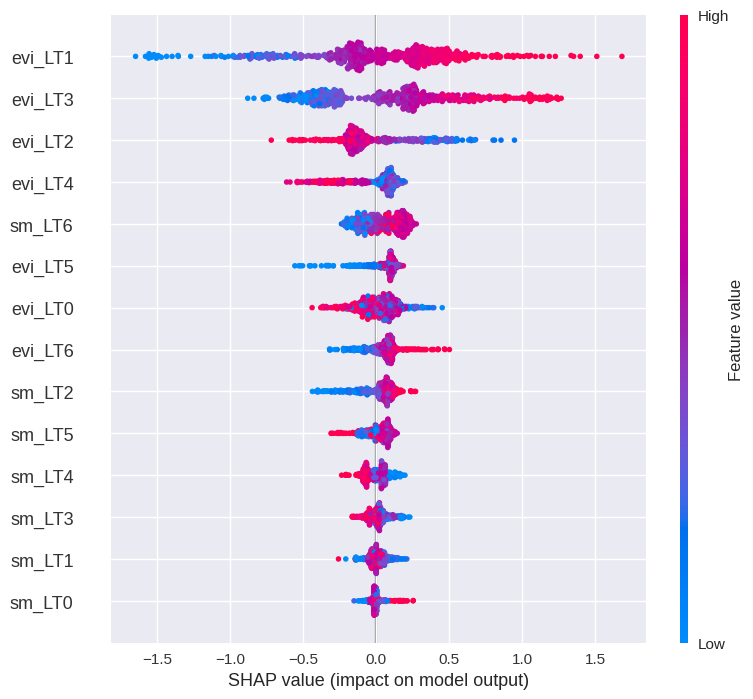

In [21]:
lead_time = 0
X_train, X_test, y_train, y_test, years_train, years_test = train_test_split(file, lead_time)

estimator = xgb.XGBRegressor(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42  # Added for reproducibility
)
pipeline = Pipeline([('scalar', StandardScaler()), ('xgb', estimator)])

# Train pipeline
pipeline.fit(X_train, y_train)

# Extract the trained model from pipeline
model = pipeline.named_steps['xgb']

# Use pipeline transform on X_test before passing to explainer if needed
X_test_transformed = pipeline[:-1].transform(X_test)  # apply all steps except the final estimator

# Create SHAP explainer using transformed train input
X_train_transformed = pipeline[:-1].transform(X_train)
explainer = shap.Explainer(model, X_train_transformed)

# Calculate SHAP values on transformed test input
shap_values = explainer(X_test_transformed)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test_transformed, feature_names=X_test.columns)